In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install require Lib, PVLib, Pyowm, Paramiko

In [2]:
#pip install pvlib

In [3]:
#pip install pyowm

In [4]:
#pip install paramiko

# Import Require libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from pathlib import Path
import os
import itertools
import pytz

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [7]:
from pvlib import location
from pvlib import irradiance
#from matplotlib import pyplot as plt

# Define strcuture for the model

In [8]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers,bidirectional):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out
LSTM

__main__.LSTM

# Load the model and Scaler

### Load Model

In [9]:
#PATH = "../input/pv-model/Solar_power_model.pt"
#PATH = "../input/pv-model/Clear_sky_update.pt"
path = Path.cwd()
PATH = "Clear_sky_update.pt"

# Input parameters for the model structure

input_size = 10
hidden_size = 128
num_layers = 1
seq_length =24
num_classes = 1
bidirectional = True

# Load
device = torch.device('cpu')

# Load
device = torch.device('cpu')
model = LSTM(num_classes, input_size, hidden_size, num_layers,bidirectional)
model.load_state_dict(torch.load(PATH, map_location=device))

# Load the model
#model = LSTM(num_classes, input_size, hidden_size, num_layers,bidirectional)
#model.load_state_dict(torch.load(PATH))
#model.eval()

<All keys matched successfully>

### Load scaler

In [10]:
from joblib import dump, load

# Load Scaler
#sc_X=load('../input/pv-model/sc_X.bin')
#sc_Y=load('../input/pv-model/sc_Y.bin')

sc_X=load('scaler_X_Clear_sky_update.bin')
sc_Y=load('scaler_Y_Clear_sky_update.bin')
sc_W=load('scaler_W_Clear_sky_update.bin')

## Weather API

### Print hourly forecast for next 48 hours from weather API
* Note that the time is in UTC (GMT + 0)

# Log the Temperature,Cloud Wind and AirPressure forecast data

In [11]:
from pyowm.owm import OWM
from pyowm.utils import timestamps
from datetime import datetime, timedelta, timezone
from pyowm.utils import timestamps, formatting

def get_history_weather(key,pass_hours):
    
    """ Arg:
        - key(str): key get from owm site
        - pass_hours: number of pass hours data
   
    Returns:
        - weather : dataframe with temperature,cloud and wind data of passs hours
    """
    
    #owm = OWM('1a4df9d4817c3d16e92b272d59531753')
    owm = OWM(key)
    mgr = owm.weather_manager()
    
    # what is the epoch for yesterday at this time?
    
    yesterday_epoch = formatting.to_UNIXtime(timestamps.yesterday())
    one_call_yesterday = mgr.one_call_history(lat=51.98787601885725, lon=5.950209138832937, dt=yesterday_epoch)
    
    # today weather up to current time
    
    today = int((datetime.utcnow() - timedelta(hours=1)).replace(tzinfo=timezone.utc).timestamp())
    #print(today)
    #today = today.astimezone(pytz.utc)
    one_call_today = mgr.one_call_history(lat=51.98787601885725, lon=5.950209138832937, dt=today)

    #weather = pd.DataFrame(columns = ['time','temperature','cloud','wind','rain'])
    
    weather = pd.DataFrame(columns = ['temperature','cloud','wind','rain'])
    
    for i in range(len(one_call_yesterday.forecast_hourly)):

        temp    = one_call_yesterday.forecast_hourly[i].ref_time
        temp    = datetime.fromtimestamp(temp).strftime('%Y-%m-%d %H:%M:%S')
        cloud   = one_call_yesterday.forecast_hourly[i].clouds
        cloud   = np.rint(cloud*8/100)
        temperature = one_call_yesterday.forecast_hourly[i].temperature('celsius')['temp']
        wind   = one_call_yesterday.forecast_hourly[i].wind()['speed']

        if one_call_yesterday.forecast_hourly[i].status == 'rain' or one_call_yesterday.forecast_hourly[i].status == 'Rain':
            rain = 1
        else: rain = 0

        #weather = weather.append({'time': temp,'temperature': temperature,'cloud': cloud,
        #                         'wind': wind,'rain': rain},ignore_index=True)
        weather = weather.append({'temperature': temperature,'cloud': cloud,
                                 'wind': wind,'rain': rain},ignore_index=True)

    for i in range (len(one_call_today.forecast_hourly)):

        temp    = one_call_today.forecast_hourly[i].ref_time
        temp    = datetime.fromtimestamp(temp).strftime('%Y-%m-%d %H:%M:%S')
        cloud   = one_call_today.forecast_hourly[i].clouds
        cloud   = np.rint(cloud*8/100)
        temperature = one_call_today.forecast_hourly[i].temperature('celsius')['temp']
        wind   = one_call_today.forecast_hourly[i].wind()['speed']

        if one_call_today.forecast_hourly[i].status == 'rain' or one_call_today.forecast_hourly[i].status == 'Rain':
            rain = 1
        else: rain = 0


        weather = weather.append({'temperature': temperature,'cloud': cloud,
                                 'wind': wind,'rain': rain},ignore_index=True)
        
    #weather['time'] = pd.to_datetime(weather['time'])
    #weather= weather.set_index('time')
    #weather['index'] = weather.index
    #weather['index'] = weather['index'].apply(lambda x:x.to_pydatetime())
    #weather['year']  = weather['index'].apply(lambda x:x.year)
    #weather['month'] = weather['index'].apply(lambda x:x.month)
    #weather['day']   = weather['index'].apply(lambda x:x.day)
    #weather['hour']  = weather['index'].apply(lambda x:x.hour)
    
    weather = weather.tail(pass_hours)
    weather.reset_index(drop=True, inplace=True)
    return weather

## Example get pass weather data

In [34]:
passweather = get_history_weather('1a4df9d4817c3d16e92b272d59531753',12)
#passweather

In [13]:
def get_future_weather(key,future_hours):
    
    """ Arg:
        - key(str): key get from owm site
        - future_hours: number of future hours data
   
    Returns:
        - weather : dataframe with temperature,cloud and wind data of future hours
    """
    owm = OWM(key)
    mgr = owm.weather_manager()
    one_call_future = mgr.one_call(lat=51.98787601885725, lon=5.950209138832937)
    

    future_weather = pd.DataFrame(columns = ['temperature','cloud','wind','rain'])

    for i in range(len(one_call_future.forecast_hourly)):

        temp        = one_call_future.forecast_hourly[i].ref_time
        temp        = datetime.fromtimestamp(temp).strftime('%Y-%m-%d %H:%M:%S')
        #print(temp)
        cloud       = one_call_future.forecast_hourly[i].clouds
        cloud       = np.rint(cloud*8/100)
        temperature = one_call_future.forecast_hourly[i].temperature('celsius')['temp']
        wind        = one_call_future.forecast_hourly[i].wind()['speed']

        if one_call_future.forecast_hourly[i].status == 'rain' or one_call_future.forecast_hourly[i].status == 'Rain':
            rain = 1
        else: rain = 0

        future_weather = future_weather.append({'temperature': temperature,'cloud': cloud,
                                                'wind': wind,'rain': rain},ignore_index=True)
        
    #weather['time'] = pd.to_datetime(weather['time'])
    #weather= weather.set_index('time')
    #weather['index'] = weather.index
    #weather['index'] = weather['index'].apply(lambda x:x.to_pydatetime())
    #weather['year']  = weather['index'].apply(lambda x:x.year)
    #weather['month'] = weather['index'].apply(lambda x:x.month)
    #weather['day']   = weather['index'].apply(lambda x:x.day)
    #weather['hour']  = weather['index'].apply(lambda x:x.hour)
    
    #future_weather = future_weather[0:future_hours]
    #future_weather.reset_index(drop=True, inplace=True)
    #future_weather = future_weather.head(future_hours)
    future_weather = future_weather[1:future_hours+1]
    return future_weather

## Example get future weatherdata

In [32]:
futureweather = get_future_weather('1a4df9d4817c3d16e92b272d59531753',24)
#futureweather

# Request measured data from the raspberry Pi

## Make a request function

In [15]:
import os
from pathlib import Path
import os
import sqlite3
import paramiko
import numpy as np
import ftplib
import ipywidgets as widgets
from IPython.display import display

def get_modbus(host_ip,port,username,password,pass_hours):
     
    """ Arg:
        - host_ip  :     IP address of the data site
        - port     :     Port number of the data site
        - username :     
        - password :
        - pass_hours :   number of pass data point
   
    Returns:
        - PV_data : dataframe with pass 12 hours solar power data in hourly rate.
    """
    #host = "80.113.19.27"
    #port = 22
    #password = "controlsystem"
    #username = "pi"

    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(host_ip, port, username, password)

    ftp = ssh.open_sftp()
    
    data_d = ftp.chdir('/mnt/dav/Data')
    cwd=ftp.getcwd()
    path = Path.cwd()
    
    ftp.get("modbusData.db","modbusData.db",callback=None)
    
    conn = sqlite3.connect("modbusData.db")
    query = '''SELECT * from PV'''
    PV_data= pd.read_sql_query(query,conn)
    PV_data['Time']=pd.to_datetime(PV_data['Time'],unit='s')
    
    # PV data 
    PV_data= PV_data.sort_values(by='Time', ascending=True)
    PV_data['Time']=pd.to_datetime(PV_data['Time'],unit='s')
    PV_data = PV_data.set_index('Time')
    PV_data=PV_data.resample('60min').mean()
    PV_data = PV_data.tail(pass_hours)
    
    PV_data['index'] = PV_data.index
    PV_data['index'] = PV_data['index'].apply(lambda x:x.to_pydatetime())
    PV_data['year']  = PV_data['index'].apply(lambda x:x.year)
    PV_data['month'] = PV_data['index'].apply(lambda x:x.month)
    PV_data['day']   = PV_data['index'].apply(lambda x:x.day)
    PV_data['hour']  = PV_data['index'].apply(lambda x:x.hour)
    
    return PV_data

## Example get modbus data

In [16]:
host_ip = "192.168.110.7"
port = 22
password = "controlsystem"
username = "pi"
pass_hours = 12

PV_data = get_modbus(host_ip,port,username,password,pass_hours)

In [17]:
#PV_data

# Funtion to get day of the year data

## Make cyclic_data

In [18]:
def sin_transform(values):
    return np.sin(2*np.pi*values/len(set(values)))

def cos_transform(values):
    return np.cos(2*np.pi*values/len(set(values)))


def cyclic_data(tz,lat,lon,first_doy,first_dony):
    
    """ Arg:
        - tz         :     time zone
        - lat        :     latitude
        - lon        :     longitude
        - first_doy  :     first day of the year
        - first_dony :     first day of next year
   
    Returns:
        - clearsky   : dataframe with clear sky of the year and clyclic_data
        
        https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
        https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
        https://www.datasciencecentral.com/profiles/blogs/how-to-make-time-data-cyclical-for-prediction
        
    """
    # Create location object to store lat, lon, timezone
    site = location.Location(lat, lon, tz=tz)

    times = pd.date_range(start=first_doy, end=first_dony, freq='1H',tz=site.tz) #tz='UTC'
    #print (idx.to_pydatetime())
    idx =  pd.DataFrame(times.to_pydatetime(),columns =['Time'])
    idx['year']  = idx['Time'].apply(lambda x:x.year)
    idx['month'] = idx['Time'].apply(lambda x:x.month)
    idx['day']   = idx['Time'].apply(lambda x:x.day)
    idx['hour']  = idx['Time'].apply(lambda x:x.hour)

    temp=np.zeros(len(idx['day']))
    day=1
    month=1
    year=2021
    doy=1

    for i in range(len(idx['day'])):


        if idx['month'][i] > month:
            month = month + 1
            day = 0

        if idx['day'][i] > day:
            day=day+1
            doy = doy + 1

        if idx['year'][i] > year:
            year  =  year + 1
            doy   = 1
            month = 1
            day   = 1
        temp[i] = doy

    idx['doy'] = temp

    idx['dayofyear_sin'] = sin_transform(idx['doy'])
    idx['dayofyear_cos'] = cos_transform(idx['doy'])
    idx['hour_sin']      = sin_transform(idx['hour'])
    idx['hour_cos']      = cos_transform(idx['hour'])

    
    #times    
    clearsky = site.get_clearsky(times)
    
    # shift 1 hour up for correction   
    clearsky['ghi'] = clearsky['ghi'].shift(-1)
    clearsky['ghi'] = clearsky['ghi'].fillna(0)
    
    # drop dni and dhi
    clearsky.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columnsclearsky2021.reset_index(inplace=True)
    clearsky.reset_index(inplace=True)
    clearsky['index'] = clearsky['index'].apply(lambda x:x.to_pydatetime())
    clearsky['year']  = clearsky['index'].apply(lambda x:x.year)
    clearsky['month'] = clearsky['index'].apply(lambda x:x.month)
    clearsky['day']   = clearsky['index'].apply(lambda x:x.day)
    clearsky['hour']  = clearsky['index'].apply(lambda x:x.hour)

    cyclic_data = pd.merge(clearsky,idx, on=['year','month','day','hour'])
    cyclic_data['ghi']=cyclic_data['ghi'].values*11.52
    
    return cyclic_data

In [19]:
def get_current_cyclic_data(cyclic_data,solar_data):
    
    """ Arg:
        - cyclic_data         :     cyclic data
        - solar_data          :     PV input data
      
    Returns:
        - pass_cyclic   : get n hours (the number of hours = number of pass PV hours) 
                          to current time of cyclic data    
    """
   
    current_cyclic = pd.merge(solar_data,cyclic_, on=['year','month','day','hour'])
    current_cyclic.drop(current_cyclic.columns.difference(['dayofyear_sin',
                                                           'dayofyear_cos','hour_sin',
                                                           'hour_cos','ghi']), 1, inplace=True)
    
    current_cyclic = current_cyclic[["dayofyear_sin", "dayofyear_cos", 
                                     "hour_sin","hour_cos","ghi"]]
    
    return current_cyclic


## example get Current cyclicdata 

In [20]:
tz = 'UTC'
lat, lon = 51.98787601885725, 5.950209138832937
first_doy= '1/1/2021'
first_dony = '01/01/2022'

# get cyclic data

cyclic_ = cyclic_data(tz,lat,lon,first_doy,first_dony)

# get current 
current_c_data = get_current_cyclic_data(cyclic_,PV_data)
current_c_data.head(1)

,dayofyear_sin,dayofyear_cos,hour_sin,hour_cos,ghi
0,0.47116,-0.882048,1.0,6.123234e-17,5058.133988


In [21]:
#current_c_data

In [22]:
import pytz

def get_future_cyclic_data(cyclic_data,hours):
    
    """ Arg:
    
        - cyclic_data         :     cyclic_data
        - hours               :     number of future data
      
    Returns:
        - future_cyclic_data  : get n hours  of future cyclic data    
    """
    
    #hours =24
    doy_temp = pd.DataFrame(columns = ['temp'])
    future_hours = []

    for i in range(hours):

        temp = datetime.utcnow().replace(microsecond=0, second=0, minute=0) + timedelta(hours=i+1)# time GMT+2
        future_hours = np.append(future_hours,temp)
        doy_temp.loc[future_hours[i]]= 0

        doy_temp['index'] = doy_temp.index
        doy_temp['index'] = doy_temp['index'].apply(lambda x:x.to_pydatetime())
        doy_temp['year']  = doy_temp['index'].apply(lambda x:x.year)
        doy_temp['month'] = doy_temp['index'].apply(lambda x:x.month)
        doy_temp['day']   = doy_temp['index'].apply(lambda x:x.day)
        doy_temp['hour']  = doy_temp['index'].apply(lambda x:x.hour)

    future_cyclic_data = pd.merge(doy_temp, cyclic_data, on=['year','month','day','hour'])
    
    future_cyclic_data.drop(future_cyclic_data.columns.difference(['dayofyear_sin','dayofyear_cos',
                                                                   'hour_sin','hour_cos','ghi']), 1, inplace=True)
    
    future_cyclic_data = future_cyclic_data[["dayofyear_sin", "dayofyear_cos", 
                                             "hour_sin","hour_cos","ghi"]]
    #future_data.head(1)
    
    return future_cyclic_data

## Example get future cyclic data

In [23]:
future_cyclic_data = get_future_cyclic_data(cyclic_,24)
future_cyclic_data.head(1)

,dayofyear_sin,dayofyear_cos,hour_sin,hour_cos,ghi
0,0.47116,-0.882048,-1.0,-1.836970e-16,312.842909


In [24]:
#future_cyclic_data

## Normalize the datas into the same range for model inputs.
* Power is in the range of 1000 wat
* Temperature is in the range of -10 to 40 degree.
*  Cloud cover is in the range from 0 to 8.
* Wind speed in m/s
* Air pressrure in Pa

They need to be converted to the same range before feeding to the model.

## Put everything together for the prediction

In [25]:
import time

def waitUntil(condition): #defines function
    wU = True
    while wU == True:
        if condition: #checks the condition
            print(condition)
            break
            #output
            wU = False
        time.sleep(60*10) #waits 60s for preformance

#waitUntil(len(PV_data['P1']) >=12) #runs function (output MUST be another function)

In [26]:
current_c_data.shape

(12, 5)

In [27]:
Power = PV_data['P1'].values    
Power = np.reshape(Power, (-1, 1))[0:24]
Power = np.nan_to_num(Power)

# Stack Power, Temperaure and Cloud data together.
input_data = np.hstack((Power,passweather,current_c_data))
input_data[:,9] = input_data[:,9]*(1-(input_data[:,2]/9 * input_data[:,4]))
input_data = sc_X.transform(input_data)
input_data = input_data.reshape((1,input_data.shape[0], input_data.shape[1]))

# Convert data into torch tensor 
input_data = Variable(torch.Tensor(np.array(input_data)))

# Weather data
Weather = np.hstack((futureweather,future_cyclic_data))
Weather[:,8] = Weather[:,8]*(1-(Weather[:,1]/9 * Weather[:,3]))
Weather = sc_W.transform(Weather)
Weather = Variable(torch.Tensor(np.array(Weather)))

#Create an empty array
predict =np.array([])

# Define number of prediction hours.
predict_hour = 4

for i in range(predict_hour): # The number of prediction steps
    
    # call the model for predicting the Solar power in the next hour.
    
    Predic_P    = model(input_data)
    
    # Use the predicted value to predict the next steps (2nd,3rd....) hours
    
    if i < len(Weather):
        #Predic_W = Weather[0:i+1]
        Predic_W = Weather[i]
    else:
        Predic_W = Variable(torch.Tensor(np.array([0, 0,0])))
    
    # Add the predicted values to the input set for the next prediction points.
    # Remove the 1st row, return to 24 points input
    
    new_input_data =  torch.vstack((input_data[0,:,0:11],torch.cat((Predic_P[0],Predic_W),0)))
    new_input_data =  new_input_data[torch.arange (new_input_data.size (0))!=0]
    
    input_data[0] = new_input_data
    #print(input_data[0,-1,:])
    
    # Add all prediction value together. 
    Predic_P = Predic_P.detach().numpy()  
    #print(Predic_P)
    predict = np.append(predict,Predic_P)   

# Plot the prediction

16.21833571981847


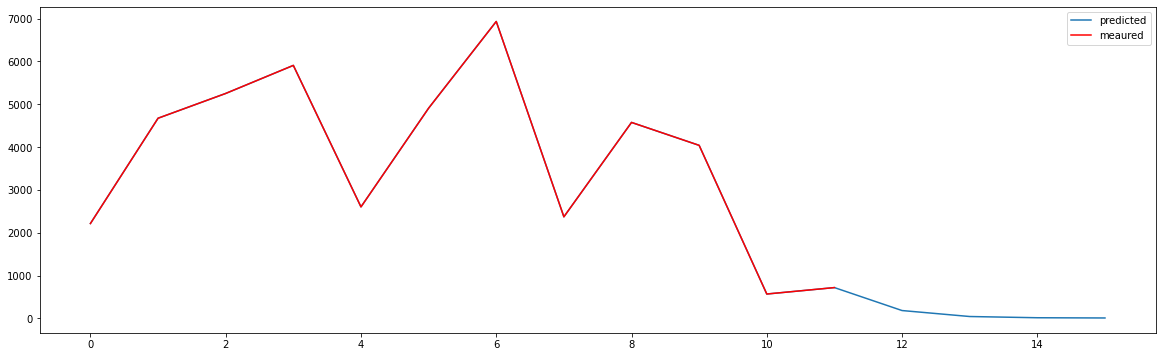

In [28]:
#predict = np.append(predict,Predic_P)
#plt.plot(PV_data['P1'][20:24],label='meaured')

predict_tf= np.reshape(predict, (len(predict), 1))
predict_tf = sc_Y.inverse_transform(predict_tf)
predict_tf = np.append(PV_data['P1'].values,predict_tf)
# Solar power always > 0
predict_tf[predict_tf < 0] = 0

plt.figure(figsize=(20,6)) #plotting
plt.plot(predict_tf,label='predicted')
plt.plot(PV_data['P1'].values[0:len(PV_data['P1'])],'r',label='meaured')
#plt.plot(predict_c[0:-1],'--',label='predicted_')
#plt.xlim([20,28])
plt.legend()
plt.show
print(predict_tf[-2])

# Add future datetime for visulization, the data time is in 

2021-06-03 18:00:00
2021-06-03 19:00:00
2021-06-03 20:00:00
2021-06-03 21:00:00


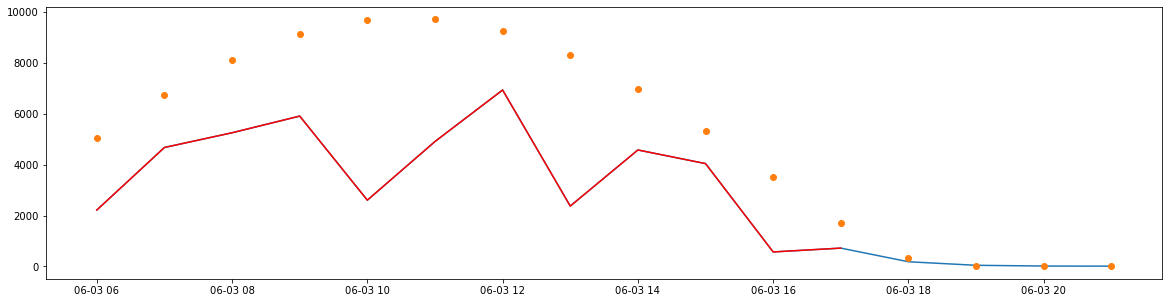

In [29]:
from datetime import datetime, timedelta
future_hours = []
PV_data_predict = PV_data['P1'].copy()

ghidata = current_c_data['ghi'].copy()
ghidata.index = PV_data.index

#future_hours = datetime.now().replace(microsecond=0, second=0, minute=0) + timedelta(hours=i+1)
#future_hours = np.append(future_hours,future_hours)

for i in range(predict_hour):
    temp = datetime.utcnow().replace(microsecond=0, second=0, minute=0) + timedelta(hours=i+1)
    #temp = temp.astimezone(pytz.utc)
    future_hours = np.append(future_hours,temp)
    #PV_data_preidct.loc[future_hours[i]]= predict_tf[-1-i]
    PV_data_predict.loc[future_hours[i]]= predict_tf[-predict_hour+i]
    ghidata.loc[future_hours[i]] = future_cyclic_data['ghi'][i]
    print(future_hours[i])
    
plt.figure(figsize=(20,5)) #plotting
plt.plot(PV_data_predict.loc['2021-04-12 09:00:00':,],label='predicted')
plt.plot(PV_data['P1'].loc['2021-04-12 09:00:00':,],'r',label='meaured')
plt.plot(ghidata,'o',label='Clear_sky')

# Make a Loop which updated every 5 minutes
* Press the Power button to run

In [30]:
import time
import pylab as pl
from IPython import display as cleardisplay

import ipywidgets as widgets
from IPython.display import display

button = widgets.Button(description="Power")
output = widgets.Output()

display(button, output)
updatetime = 60*5

#future_data = future_data[["dayofyear_sin", "dayofyear_cos", 
#                           "hour_sin","hour_cos","ghi"]]

save_data   = pd.DataFrame(columns = ['Predict_Power',
                                      'Temperature','Cloud','Wind', 
                                      'Rain','dayofyear_sin',
                                      'dayofyear_cos','hour_sin',
                                      'hour_cos','ghi'])

def on_button_clicked(b):
    count =0
    save_ghi         = pd.DataFrame(columns = ['Power','ghi'])
    save_all_data    = pd.DataFrame(columns = ['Power','Predict','ghi'])
    current_hour = datetime.utcnow().hour
    
    # modbus 
    host_ip = "192.168.110.7"
    port = 22
    password = "controlsystem"
    username = "pi"
    
    # cyclic data 
    tz = 'UTC'
    lat, lon = 51.98787601885725, 5.950209138832937
    first_doy= '1/1/2021'
    first_dony = '01/01/2022'
    
    # weather key
    key ='1a4df9d4817c3d16e92b272d59531753'
    pass_hours = 12
    future_data = 24
    # Define predic_hour
    predict_hour = 4
    
    with output:
        
        while True:
                
            #count =0
            start = time.time()
            time.process_time()   
            elapsed = 0
            n=0
            pl.figure(figsize=(20,5))
            
            while elapsed < time.process_time():
                elapsed = time.time() - start
                # Add x and y to lists
                if elapsed >= n*updatetime:
                    #print( n*updatetime)
                    
                    # Get pass weather data
                    passweather = get_history_weather(key,pass_hours)
                 
                    # Get future weather data
                    futureweather = get_future_weather(key,future_data)
                   
                    
                   # Get PV measure data                
                    PV_data = get_modbus(host_ip,port,username,password,pass_hours)
                    print(len(PV_data['P1']))
                    waitUntil(len(PV_data['P1']) >=12) #runs function (output MUST be another function)
                    
                    # get cyclic data
                    cyclic_ = cyclic_data(tz,lat,lon,first_doy,first_dony)
                    
                    # get current cyclic data
                    current_c_data = get_current_cyclic_data(cyclic_,PV_data)
                    
                    # get future cyclic data
                    future_cyclic_data = get_future_cyclic_data(cyclic_,future_data)
                                        
                    # Prepare data for prediction
                    Power = PV_data['P1'].values
                    Power = np.reshape(Power, (-1, 1))[0:future_data]
                    Power = np.nan_to_num(Power)
                    
                    # Stack Power, weather and cyclic data together.
                    input_data = np.hstack((Power,passweather,current_c_data))
                    input_data[:,9] = input_data[:,9]*(1-(input_data[:,2]/9 * input_data[:,4]))
                    input_data = sc_X.transform(input_data)
                    input_data = input_data.reshape((1,input_data.shape[0], input_data.shape[1]))

                    # Convert data into torch tensor 
                    input_data = Variable(torch.Tensor(np.array(input_data)))

                    # Future Weather and cyclic data
                    
                    Weather = np.hstack((futureweather,future_cyclic_data))
                    Weather[:,8] = Weather[:,8]*(1-(Weather[:,1]/9 * Weather[:,3]))
                    Weather = sc_W.transform(Weather)
                    Weather = Variable(torch.Tensor(np.array(Weather)))

                    # The last data point is the current weather condition.
                    #input_data[0,-1,1:11]= Weather[0]
                    #Predic_W = Weather[0]

                    #Create an empty array
                    predict =np.array([])

                    # Define number of prediction hours.
                    predict_hour = 4

                    for i in range(predict_hour): # The number of prediction steps

                        # call the model for predicting the Solar power in the next hour.

                        Predic_P    = model(input_data)

                        # Use the predicted value to predict the next steps (2nd,3rd....) hours

                        if i < len(Weather):
                            #Predic_W = Weather[0:i+1]
                            Predic_W = Weather[i] #+1
                        else:
                            Predic_W = Variable(torch.Tensor(np.array([0, 0,0])))

                        # Add the predicted values to the input set for the next prediction points.
                        # Remove the 1st row, return to 24 points input

                        new_input_data =  torch.vstack((input_data[0,:,0:11],torch.cat((Predic_P[0],Predic_W),0)))
                        new_input_data =  new_input_data[torch.arange(new_input_data.size (0))!=0]

                        input_data[0] = new_input_data
                        #print(input_data[0,-1,:])

                        # Add all prediction value together. 
                        Predic_P = Predic_P.detach().numpy()  
                        #print(Predic_P)
                        predict = np.append(predict,Predic_P)                    
                    
                    predict_tf= np.reshape(predict, (len(predict), 1))
                    predict_tf = sc_Y.inverse_transform(predict_tf)         
                    # Solar power always > 0
                    predict_tf[predict_tf < 0] = 0


                    future_hours = []
                    PV_data_predict = PV_data['P1'].copy()
                    
                    ghi_data = current_c_data['ghi'].copy()
                    ghi_data.index = PV_data.index
                    #print(ghi_data,PV_data['P1'],C_data['ghi'])
                        #future_hours = datetime.now().replace(microsecond=0, second=0, minute=0) + timedelta(hours=i+1)
                        #future_hours = np.append(future_hours,future_hours)

                    for i in range(predict_hour):
                        
                        temp = datetime.utcnow().replace(microsecond=0, second=0, minute=0) + timedelta(hours=i+1)
                        future_hours = np.append(future_hours,temp)
                        PV_data_predict.loc[future_hours[i]]= predict_tf[-predict_hour+i]
                        ghi_data.loc[future_hours[i]] = future_cyclic_data['ghi'][i]
                   
                        #--------------------------------------
                    
                    pl.clf()
                    
                    #save_ghi['Power']        = PV_data['P1']
                    #save_ghi['ghi']          = C_data['ghi'].values

                        #plt.figure(figsize=(15,6)) #plotting
                    plt.plot(PV_data_predict.loc['2021-04-12 09:00:00':,],label='predicted')
                    plt.plot(PV_data['P1'].loc['2021-04-12 09:00:00':,],'r',label='meaured')
                    plt.plot(ghi_data,'o',label='Clear_sky')
                    plt.grid()
                    plt.legend(loc="best",prop={'size':14})
                    plt.xlabel("Time")
                    plt.ylabel("Solar Power [W/m2]")
                        #pl.plot(xs,ys)
                        #pl.plot(xs,ys2)
                    cleardisplay.clear_output(wait=True)
                    cleardisplay.display(pl.gcf())
                    
                    time_now = datetime.utcnow().replace(microsecond=0, second=0, minute=0) + timedelta(hours=0)
                    # Remember to shift predicted hour by one row up
                    
                    save_all_data.loc[time_now]= [PV_data['P1'].values[-1],
                                                  predict_tf.flatten()[-predict_hour],
                                                  current_c_data['ghi'].values[-1]]
                    
                    
                    save_data.loc[future_hours[0]]= [ predict_tf.flatten()[-predict_hour], 
                                                     futureweather['temperature'][1],futureweather['cloud'][1],
                                                     futureweather['wind'][1],futureweather['rain'][1],
                                                     future_cyclic_data.values[0][0],
                                                     future_cyclic_data.values[0][1],
                                                     future_cyclic_data.values[0][2],
                                                     future_cyclic_data.values[0][3],
                                                     future_cyclic_data.values[0][4]]
                    
                    save_ghi['Power']        = PV_data['P1'].values
                    save_ghi['ghi']          = current_c_data['ghi'].values
                    #save_ghi.loc[future_hours[0]]     = [0,0,predict_tf[-4]]
                    #save_ghi = save_ghi.append(save_ghi) 
                    

                    #save_ghi.drop_duplicates()
                    
                    PV_data_predict.loc['2021-04-12 09:00:00':,].to_csv('all_predicted_hours.csv')
                    
                    save_all_data.to_csv('data.csv')
                    save_data.to_csv('Solar_Power_prediction.csv')
                    save_ghi.to_csv('ghi.csv')
                    PV_data['P1'].to_csv('measure_data.csv')
                        
                time.sleep(updatetime)
            pl.close()
            

button.on_click(on_button_clicked)

Button(description='Power', style=ButtonStyle())

Output()